In [1]:
import datacube
dc = datacube.Datacube(app="List Products")

In [2]:
area_json = {
  "type": "FeatureCollection",
  "features": [
    {
      "type": "Feature",
      "properties": {},
      "geometry": {
        "type": "Polygon",
        "coordinates": [
          [
            [
              149.2719268798828,
              -35.217575569215505
            ],
            [
              149.5095062255859,
              -35.217575569215505
            ],
            [
              149.5095062255859,
              -34.97543887925878
            ],
            [
              149.2719268798828,
              -34.97543887925878
            ],
            [
              149.2719268798828,
              -35.217575569215505
            ]
          ]
        ]
      }
    }
  ]
}



In [3]:
lons, lats = zip(*area_json["features"][0]["geometry"]["coordinates"][0])

In [4]:
lat_extents = (min(lats), max(lats))
lon_extents = (min(lons), max(lons))

print("Lat:", lat_extents, "\n"
      "Lon:", lon_extents)

Lat: (-35.217575569215505, -34.97543887925878) 
Lon: (149.2719268798828, 149.5095062255859)


# Load Data

In [5]:
from datetime import datetime

query = dict(   latitude = lat_extents,
                longitude = lon_extents,
                output_crs = "EPSG:3577",
                time = (datetime(2018,1,1), datetime(2019,1,1)),
                resolution = (30,30))

**Scenes**

In [6]:
scenes = dc.load(product="ls8_nbart_albers",
               group_by='solar_day',
               #measurements = ["1","2","3","4","5","6","7"],
               **query)

In [7]:
#bands = {"1": "coastal_aerosol",
#         "2": "blue",
#         "3": "green",
#         "4": "red",
#         "5": "nir",
#         "6": "swir1",
#         "7": "swir2"}

In [8]:
#scenes = scenes.rename(bands)

In [9]:
scenes.isel(time = 6).swir1.plot()

In [10]:
scenes

<xarray.Dataset>
Dimensions:          (time: 40, x: 836, y: 988)
Coordinates:
  * time             (time) datetime64[ns] 2018-01-10T23:50:22.500000 ... 2018-12-28T23:50:10
  * y                (y) float64 -3.955e+06 -3.955e+06 ... -3.926e+06 -3.926e+06
  * x                (x) float64 1.564e+06 1.564e+06 ... 1.589e+06 1.589e+06
Data variables:
    coastal_aerosol  (time, y, x) int16 3578 3643 3745 3780 ... 723 662 658 612
    blue             (time, y, x) int16 3381 3433 3494 3533 ... 748 687 672 611
    green            (time, y, x) int16 3319 3432 3597 3538 ... 1040 954 981 854
    red              (time, y, x) int16 3359 3456 3608 3602 ... 1165 1147 1127
    nir              (time, y, x) int16 4102 4176 4276 4296 ... 2664 2738 1862
    swir1            (time, y, x) int16 3430 3570 3677 3587 ... 3768 3703 2772
    swir2            (time, y, x) int16 3034 3162 3306 3222 ... 2711 2605 2365
Attributes:
    crs:      EPSG:3577

**Pixel QA**

In [11]:
from datacube.helpers import ga_pq_fuser

pqa = dc.load(product="ls8_pq_albers",
               group_by='solar_day', 
               fuse_func= ga_pq_fuser,
               **query)

In [12]:
pqa

<xarray.Dataset>
Dimensions:       (time: 27, x: 836, y: 988)
Coordinates:
  * time          (time) datetime64[ns] 2018-01-10T23:50:22.500000 ... 2018-12-28T23:50:10
  * y             (y) float64 -3.955e+06 -3.955e+06 ... -3.926e+06 -3.926e+06
  * x             (x) float64 1.564e+06 1.564e+06 ... 1.589e+06 1.589e+06
Data variables:
    pixelquality  (time, y, x) int16 13311 13311 13311 ... 16383 16383 16383
Attributes:
    crs:      EPSG:3577

### Times 

In [13]:
scene_times = scenes.time.values
pqa_times = pqa.time.values  

common_times = set(scene_times).intersection(set(pqa_times))

In [14]:
scenes = scenes.sel(time = list(common_times)).sortby('time')
pqa = pqa.sel(time = list(common_times)).sortby('time')

**Build PQA mask**

In [15]:
from datacube.storage import masking
good_quality = masking.make_mask(pqa, 
                                 cloud_acca = "no_cloud",
                                 cloud_fmask = "no_cloud",
                                 cloud_shadow_acca = "no_cloud_shadow",
                                 cloud_shadow_fmask = "no_cloud_shadow",
                                 contiguous = True)
good_quality

<xarray.Dataset>
Dimensions:       (time: 27, x: 836, y: 988)
Coordinates:
  * time          (time) datetime64[ns] 2018-01-10T23:50:22.500000 ... 2018-12-28T23:50:10
  * x             (x) float64 1.564e+06 1.564e+06 ... 1.589e+06 1.589e+06
  * y             (y) float64 -3.955e+06 -3.955e+06 ... -3.926e+06 -3.926e+06
Data variables:
    pixelquality  (time, y, x) bool False False False False ... True True True
Attributes:
    crs:      EPSG:3577

In [16]:
#covered = (good_quality.pixelquality.groupby('time').mean() >0.4).values
#scenes = scenes.isel(time=covered)
#good_quality = good_quality.isel(time=covered)

### Wofs Classify Code (from AMA)  

In [17]:

import gc
import numpy as np
import xarray as xr

import datacube
# Command line tool imports
import argparse
import os
import collections
import gdal
from datetime import datetime


def wofs_classify(dataset_in, clean_mask=None, x_coord='longitude', y_coord='latitude',
                  time_coord='time', no_data=-9999, mosaic=False, enforce_float64=False):
    """
    Description:
      Performs WOfS algorithm on given dataset.
    Assumption:
      - The WOfS algorithm is defined for Landsat 5/Landsat 7
    References:
      - Mueller, et al. (2015) "Water observations from space: Mapping surface water from
        25 years of Landsat imagery across Australia." Remote Sensing of Environment.
      - https://github.com/GeoscienceAustralia/eo-tools/blob/stable/eotools/water_classifier.py
    -----
    Inputs:
      dataset_in (xarray.Dataset) - dataset retrieved from the Data Cube; should contain
        coordinates: time, latitude, longitude
        variables: blue, green, red, nir, swir1, swir2
    x_coord, y_coord, time_coord: (str) - Names of DataArrays in `dataset_in` to use as x, y,
        and time coordinates.
    Optional Inputs:
      clean_mask (nd numpy array with dtype boolean) - true for values user considers clean;
        if user does not provide a clean mask, all values will be considered clean
      no_data (int/float) - no data pixel value; default: -9999
      mosaic (boolean) - flag to indicate if dataset_in is a mosaic. If mosaic = False, dataset_in
        should have a time coordinate and wofs will run over each time slice; otherwise, dataset_in
        should not have a time coordinate and wofs will run over the single mosaicked image
      enforce_float64 (boolean) - flag to indicate whether or not to enforce float64 calculations;
        will use float32 if false
    Output:
      dataset_out (xarray.DataArray) - wofs water classification results: 0 - not water; 1 - water
    Throws:
        ValueError - if dataset_in is an empty xarray.Dataset.
    """

    def _band_ratio(a, b):
        """
        Calculates a normalized ratio index
        """
        return (a - b) / (a + b)

    def _run_regression(band1, band2, band3, band4, band5, band7):
        """
        Regression analysis based on Australia's training data
        TODO: Return type
        """

        # Compute normalized ratio indices
        ndi_52 = _band_ratio(band5, band2)
        ndi_43 = _band_ratio(band4, band3)
        ndi_72 = _band_ratio(band7, band2)

        #classified = np.ones(shape, dtype='uint8')

        classified = np.full(shape, no_data, dtype='uint8')

        # Start with the tree's left branch, finishing nodes as needed

        # Left branch
        r1 = ndi_52 <= -0.01

        r2 = band1 <= 2083.5
        classified[r1 & ~r2] = 0  #Node 3

        r3 = band7 <= 323.5
        _tmp = r1 & r2
        _tmp2 = _tmp & r3
        _tmp &= ~r3

        r4 = ndi_43 <= 0.61
        classified[_tmp2 & r4] = 1  #Node 6
        classified[_tmp2 & ~r4] = 0  #Node 7

        r5 = band1 <= 1400.5
        _tmp2 = _tmp & ~r5

        r6 = ndi_43 <= -0.01
        classified[_tmp2 & r6] = 1  #Node 10
        classified[_tmp2 & ~r6] = 0  #Node 11

        _tmp &= r5

        r7 = ndi_72 <= -0.23
        _tmp2 = _tmp & ~r7

        r8 = band1 <= 379
        classified[_tmp2 & r8] = 1  #Node 14
        classified[_tmp2 & ~r8] = 0  #Node 15

        _tmp &= r7

        r9 = ndi_43 <= 0.22
        classified[_tmp & r9] = 1  #Node 17
        _tmp &= ~r9

        r10 = band1 <= 473
        classified[_tmp & r10] = 1  #Node 19
        classified[_tmp & ~r10] = 0  #Node 20

        # Left branch complete; cleanup
        del r2, r3, r4, r5, r6, r7, r8, r9, r10
        gc.collect()

        # Right branch of regression tree
        r1 = ~r1

        r11 = ndi_52 <= 0.23
        _tmp = r1 & r11

        r12 = band1 <= 334.5
        _tmp2 = _tmp & ~r12
        classified[_tmp2] = 0  #Node 23

        _tmp &= r12

        r13 = ndi_43 <= 0.54
        _tmp2 = _tmp & ~r13
        classified[_tmp2] = 0  #Node 25

        _tmp &= r13

        r14 = ndi_52 <= 0.12
        _tmp2 = _tmp & r14
        classified[_tmp2] = 1  #Node 27

        _tmp &= ~r14

        r15 = band3 <= 364.5
        _tmp2 = _tmp & r15

        r16 = band1 <= 129.5
        classified[_tmp2 & r16] = 1  #Node 31
        classified[_tmp2 & ~r16] = 0  #Node 32

        _tmp &= ~r15

        r17 = band1 <= 300.5
        _tmp2 = _tmp & ~r17
        _tmp &= r17
        classified[_tmp] = 1  #Node 33
        classified[_tmp2] = 0  #Node 34

        _tmp = r1 & ~r11

        r18 = ndi_52 <= 0.34
        classified[_tmp & ~r18] = 0  #Node 36
        _tmp &= r18

        r19 = band1 <= 249.5
        classified[_tmp & ~r19] = 0  #Node 38
        _tmp &= r19

        r20 = ndi_43 <= 0.45
        classified[_tmp & ~r20] = 0  #Node 40
        _tmp &= r20

        r21 = band3 <= 364.5
        classified[_tmp & ~r21] = 0  #Node 42
        _tmp &= r21

        r22 = band1 <= 129.5
        classified[_tmp & r22] = 1  #Node 44
        classified[_tmp & ~r22] = 0  #Node 45

        # Completed regression tree

        return classified

    # Default to masking nothing.
    if clean_mask is None:
        clean_mask = create_default_clean_mask(dataset_in)
    
    # Extract dataset bands needed for calculations
    blue = dataset_in.blue
    green = dataset_in.green
    red = dataset_in.red
    nir = dataset_in.nir
    swir1 = dataset_in.swir1
    swir2 = dataset_in.swir2

    # Enforce float calculations - float64 if user specified, otherwise float32 will do
    dtype = blue.values.dtype  # This assumes all dataset bands will have
    # the same dtype (should be a reasonable
    # assumption)

    if enforce_float64:
        if dtype != 'float64':
            blue.values = blue.values.astype('float64')
            green.values = green.values.astype('float64')
            red.values = red.values.astype('float64')
            nir.values = nir.values.astype('float64')
            swir1.values = swir1.values.astype('float64')
            swir2.values = swir2.values.astype('float64')
    else:
        if dtype == 'float64':
            pass
        elif dtype != 'float32':
            blue.values = blue.values.astype('float32')
            green.values = green.values.astype('float32')
            red.values = red.values.astype('float32')
            nir.values = nir.values.astype('float32')
            swir1.values = swir1.values.astype('float32')
            swir2.values = swir2.values.astype('float32')

    shape = blue.values.shape
    classified = _run_regression(blue.values, green.values, red.values, nir.values, swir1.values, swir2.values)

    classified_clean = np.full(classified.shape, no_data, dtype='float64')
    classified_clean[clean_mask] = classified[clean_mask]  # Contains data for clear pixels

    # Create xarray of data
    x_coords = dataset_in[x_coord]
    y_coords = dataset_in[y_coord]

    time = None
    coords = None
    dims = None

    if mosaic:
        coords = [y_coords, x_coords]
        dims = [y_coord, x_coord]
    else:
        time_coords = dataset_in[time_coord]
        coords = [time_coords, y_coords, x_coords]
        dims = [time_coord, y_coord, x_coord]

    data_array = xr.DataArray(classified_clean, coords=coords, dims=dims)

    if mosaic:
        dataset_out = xr.Dataset({'wofs': data_array},
                                 coords={y_coord: y_coords, x_coord: x_coords})
    else:
        dataset_out = xr.Dataset(
            {'wofs': data_array},
            coords={time_coord: time_coords, y_coord: y_coords, x_coord: x_coords})

    return dataset_out

### Run wofs classify

In [18]:
water_classes = wofs_classify(scenes, clean_mask = good_quality.pixelquality.values, no_data = np.nan, x_coord='x', y_coord = "y")

In [19]:
%matplotlib inline

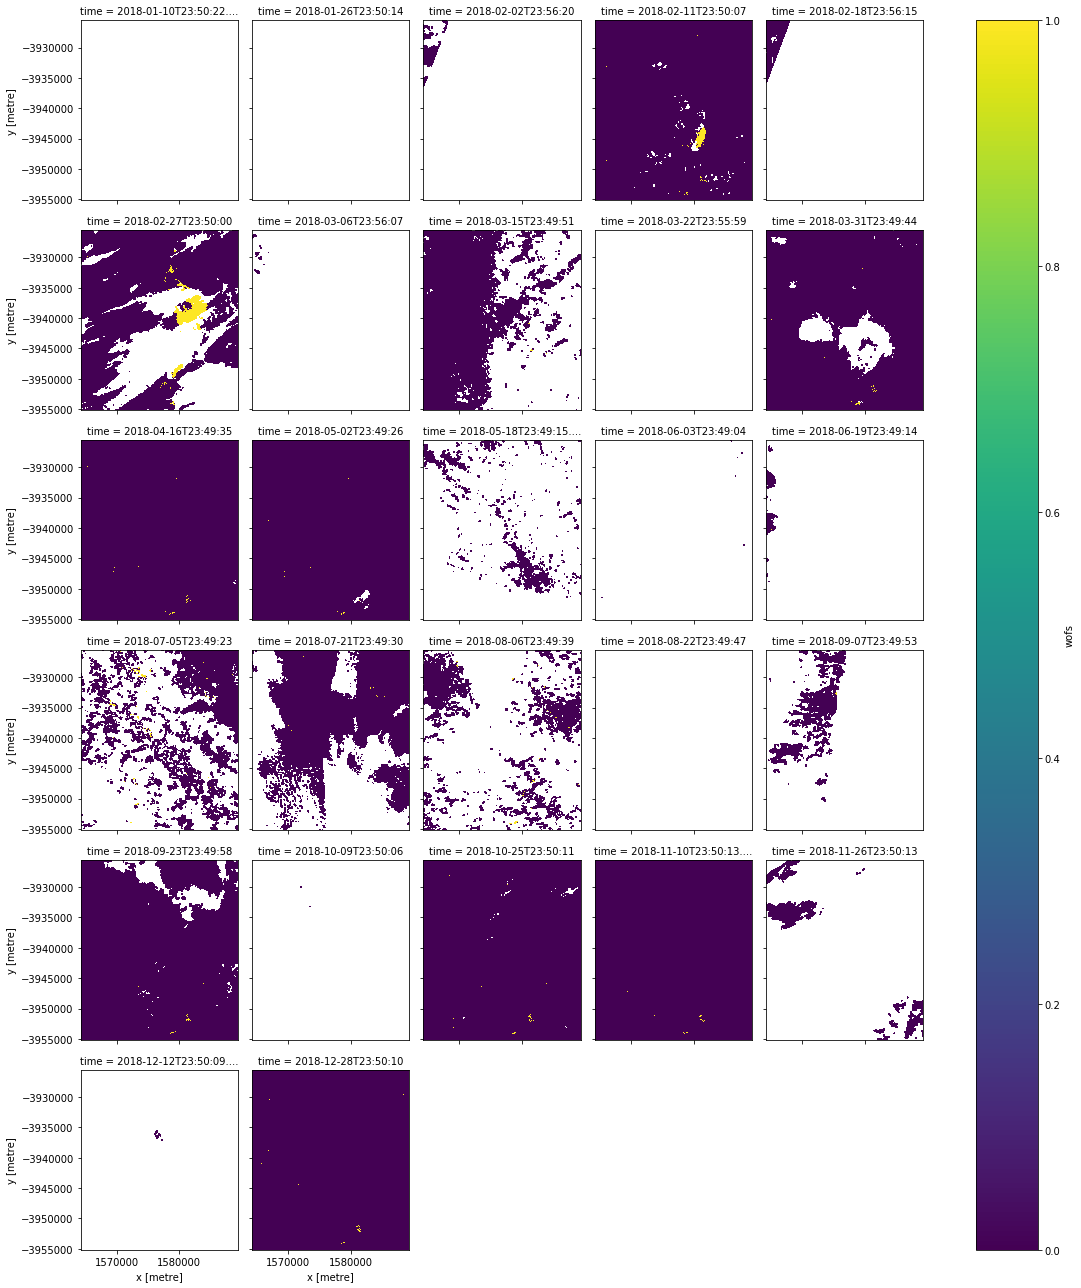

In [20]:
import matplotlib.pyplot as plt

water_classes.wofs.plot(col='time', col_wrap=5)

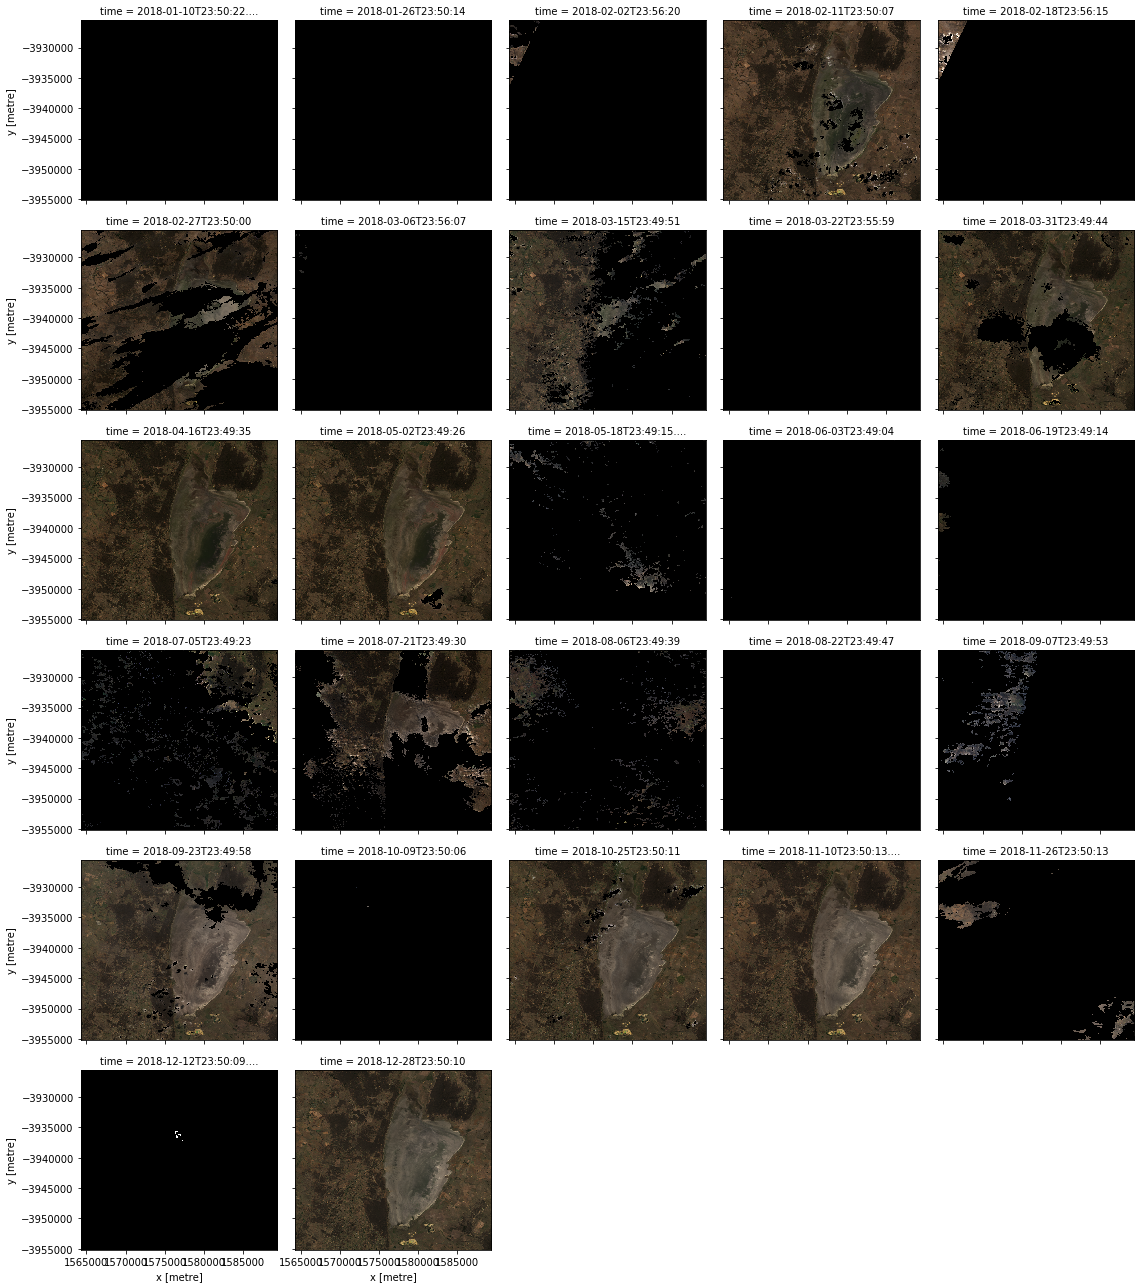

In [21]:
scenes[['red','green','blue']].to_array().where(good_quality.pixelquality.values,0).plot.imshow(col='time',col_wrap=5, 
                                                                          vmin=0, vmax=4000)

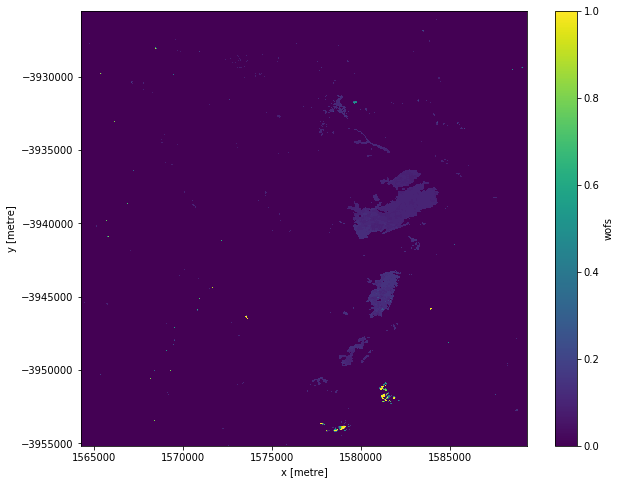

In [22]:
plt.figure(figsize = (10,8))
water_classes.wofs.mean(dim = 'time').plot()

In [23]:
# Ensure the output directory exists before writing to it.
output_file_name  =  "output/l8_wofs_2018.nc"

In [24]:
water_classes

<xarray.Dataset>
Dimensions:  (time: 27, x: 836, y: 988)
Coordinates:
  * time     (time) datetime64[ns] 2018-01-10T23:50:22.500000 ... 2018-12-28T23:50:10
  * y        (y) float64 -3.955e+06 -3.955e+06 ... -3.926e+06 -3.926e+06
  * x        (x) float64 1.564e+06 1.564e+06 1.564e+06 ... 1.589e+06 1.589e+06
Data variables:
    wofs     (time, y, x) float64 nan nan nan nan nan ... 0.0 0.0 0.0 0.0 0.0

In [25]:
scenes.attrs

OrderedDict([('crs', CRS('EPSG:3577'))])

In [ ]:
dataset_to_output =  water_classes.assign_attrs(scenes.attrs)
datacube.storage.storage.write_dataset_to_netcdf(dataset_to_output, output_file_name)

In [ ]:
!ls output/